In [ ]:
# --- Import additional layers and tools for experimentation ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Bidirectional, Dropout, Input, Layer
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("/content/drive/MyDrive/PrognosAI_OCT25/Data/rolling_window_sequences.npy")      # Feature array

# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("/content/drive/MyDrive/PrognosAI_OCT25/Data/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (152559, 30, 66)
y shape: (152559,)


In [ ]:
from sklearn.model_selection import train_test_split
# Split into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Sample X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (122047, 30, 66) (122047,)
Val shape: (30512, 30, 66) (30512,)
Sample X_train[0] batch shape: (30, 66)
First 5 RUL targets: [ 56. 296.  86. 122. 121.]


In [ ]:
import tensorflow as tf
# Data Pipeline / Generator (optional, for very large data)
# Keras can accept Numpy arrays directly in fit(), so for most practical cases, we can skip writing a custom generator
# If memory is a concern, use tf.data.Dataset.from_tensor_slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Traning Setup: Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint('best_model.keras', monitor='val_loss', verbose=1
)

In [ ]:
# Bidirectional LSTM layer to capture forward and backward temporal dependencies
def build_bidirectional_lstm_model(input_shape, lstm_units=64, dropout_rate=0.3):
    model = Sequential([
        Bidirectional(LSTM(lstm_units, activation='tanh', return_sequences=False),
                      input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(1)
    ])
    return model

model_stacked = build_bidirectional_lstm_model(input_shape=(X.shape[1], X.shape[2]))
model_stacked.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
model_stacked.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,201 (262.50 KB)

 Trainable params: 67,201 (262.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model Training
history = model_stacked.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, model_ckpt]
)

Epoch 1/200
1900/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30904.0801
Epoch 1: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 30891.6191 - val_loss: 23902.2500 - learning_rate: 1.0000e-04
Epoch 2/200
1905/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 22726.9512
Epoch 2: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 22724.8242 - val_loss: 18837.7930 - learning_rate: 1.0000e-04
Epoch 3/200
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17960.4590
Epoch 3: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 17959.9141 - val_loss: 14970.4316 - learning_rate: 1.0000e-04
Epoch 4/200
1905/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14349.4814
Epoch 4: saving model to best_model.keras
1907/1907 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 14348.2568 - val_loss: 12144.0713 - learning_rate: 1.0000e-04
Epoch 5/200
1902/1907 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11713.3945
Epoch 

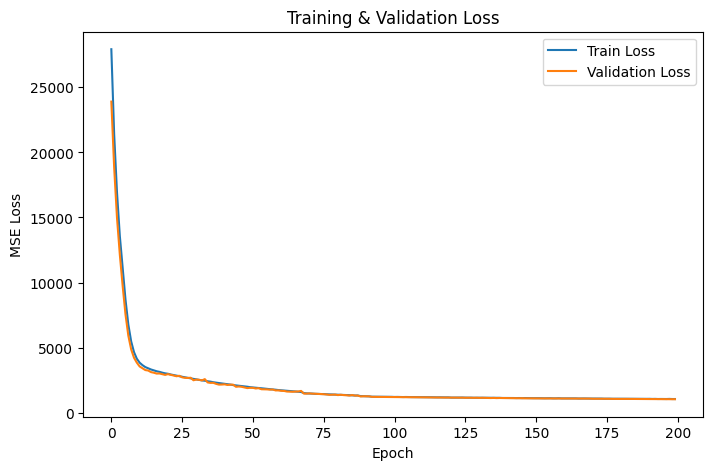

In [ ]:
import matplotlib.pyplot as plt
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


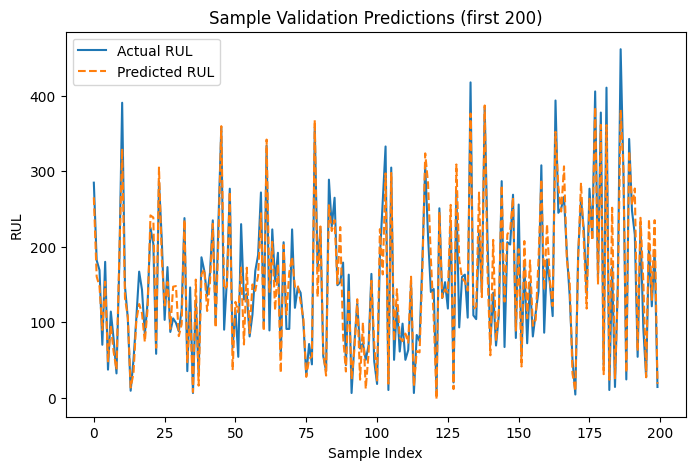

In [ ]:
# Verify Model Predictions
val_pred = model_stacked.predict(X_val[:200]).flatten()
plt.figure(figsize=(8,5))
plt.plot(y_val[:200], label='Actual RUL')
plt.plot(val_pred, label='Predicted RUL', linestyle='--')
plt.title('Sample Validation Predictions (first 200)')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.show()